# Иморт библиотек

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import scipy as sp
import seaborn as sns

In [4]:
from collections import Counter

# Загрузка данных

In [5]:
points = np.load('lab1_data/points.npy')

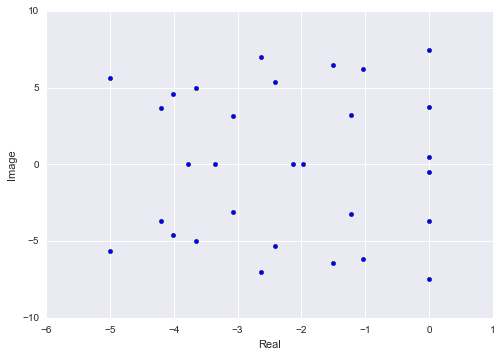

In [6]:
axes().set_ylabel('Image') 
axes().set_xlabel('Real')
scatter(points.real, points.imag)

# Постановка задачи

Задано $N=30$ исходных собственных чисел матрицы $A$. Требуется редуцировать порядок системы.
Если на вход системе подается испульсная дельта-функция Дирака $\delta(\theta - t_0)$, то получаем на выходе
$$y_k=\sum\limits_{p=1}^{P} \sum\limits_{j=1}^{n_p} \frac{(k \Delta)^{j-1}}{(j-1)!}(f_{p_j}^c \cos k \Delta \beta_p + f_{p_j}^s \sin k \Delta \beta_p) \exp(-\alpha_p k \Delta)$$


Задача – определить параметры редуцированной системы, а именно $f_q^c, f_q^s, \alpha_q, \beta_q$, когда
$$\tilde y_k = \sum\limits_{q=1}^Q (f_q^c \cos k \Delta \beta_q + f_q^s \sin k \Delta \beta_q) \exp(-\alpha_q k \Delta)$$

# Выполнение работы

In [7]:
def generate_f(size):
    """
    Generates random numbers of given size uniformly in (-1, -0.9) join (0.9, 1).
    """
    arr = random.uniform(0.9, 1.1, size)
    arr[arr > 1] -= 2
    return arr

In [8]:
def get_impulse_sum(f_c, f_s, alpha, beta, delta=0.05):
    """
    Creates sum calculator with given parameters and returns it.
    """
    def sum_calculator(k):
        coef = f_c * np.cos(k * delta * beta) + f_s * np.sin(k * delta * beta)
        exp_val = np.exp(- alpha * k * delta)
        return np.dot(coef, exp_val)
    return sum_calculator

In [9]:
def calculate_delta(eigenvalues):
    return min(2 / (5 * max(abs(eigenvalues.real))), np.pi / (5 * max(abs(eigenvalues.real))))

In [10]:
class InitialImpulse(object):
    def __init__(self, eigenvalues):
        self.delta = calculate_delta(eigenvalues)
        cnt = Counter(eigenvalues)
        unique_eigenvalues = cnt.keys()
        eigen_count = len(unique_eigenvalues)
        f_c, f_s = generate_f((2, eigen_count))
        self.eigenvalues = concatenate(tuple(repeat(value, cnt[value]) for value in unique_eigenvalues))
        self.f_cc = concatenate(tuple(repeat(f_c[i], cnt[value]) for i, value in enumerate(unique_eigenvalues)))
        self.f_ss = concatenate(tuple(repeat(f_s[i], cnt[value]) for i, value in enumerate(unique_eigenvalues)))
        print('Eigenvalues: ', self.eigenvalues)
        print('f_c: ', self.f_cc)
        print('f_s: ', self.f_ss)
        print('Delta: ', self.delta)
        
    def functor(self):
        return vectorize(get_impulse_sum(self.f_cc, self.f_ss, -self.eigenvalues.real, self.eigenvalues.imag, self.delta))

In [11]:
impulse = InitialImpulse(points)

Eigenvalues:  [ 0.00000000+0.488119j  0.00000000-0.488119j -4.20594167+3.704083j
 -3.07762250+3.129952j -4.01719625+4.616544j  0.00000000+3.717795j
 -4.99519292+5.620215j -2.41375917+5.33778j  -1.49858875-6.442257j
 -2.63104708+6.993242j -1.49858875+6.442257j  0.00000000+7.478414j
 -3.65719292-4.976066j -1.03305958+6.197849j -2.41375917-5.33778j
 -4.99519292-5.620215j  0.00000000-7.478414j -2.63104708-6.993242j
 -1.03305958-6.197849j -3.35096167+0.j       -4.01719625-4.616544j
 -1.22275083+3.242653j -4.20594167-3.704083j -3.07762250-3.129952j
 -1.22275083-3.242653j  0.00000000-3.717795j -3.65719292+4.976066j
 -3.78557500+0.j       -2.13498583+0.j       -1.97344750+0.j      ]
f_c:  [-0.99740399 -0.93149025 -0.94040093 -0.9277157   0.97393318  0.92715824
 -0.94694202  0.90532285  0.91672062 -0.90495054  0.91666653  0.96777727
  0.90986433 -0.97765229 -0.90823509 -0.9610488   0.90933693  0.96952902
 -0.98114671 -0.99411349 -0.93428792 -0.9982942  -0.99447083 -0.96761123
  0.90395753 -0.96

In [27]:
def generate_cost_func(support, complexity):
    """
    Example approximator.
    """
    value = impulse.functor()(support)
    delta = impulse.delta
    def approximator(vec):
        params = vec.reshape((4, complexity))
        return mean(abs(value -  vectorize(get_impulse_sum(*params, delta))(support)))
    return approximator

In [43]:
Q = 6
appr = generate_cost_func(arange(0, 500, 1), Q)
f_cc = impulse.f_cc[impulse.eigenvalues.real == 0]
f_ss = impulse.f_ss[impulse.eigenvalues.real == 0]
alpha = zeros(Q)
beta = impulse.eigenvalues[impulse.eigenvalues.real == 0].imag
init_params = concatenate((f_cc, f_ss, alpha, beta))
#print(appr(init_params))
solution = sp.optimize.fmin_bfgs(appr, init_params)
#print(solution.reshape((4, Q)))
#solution = init_params

         Current function value: 0.034182
         Iterations: 0
         Function evaluations: 2612
         Gradient evaluations: 100


In [39]:
y_appr = vectorize(get_impulse_sum(*solution.reshape((4, Q)), DELTA))